In [90]:
def clp(G, B, gasilci, cas):
    # vhodni podatki:
    #     G           izbran graf
    #     B           vozlišča, ki na začetku zgorijo
    #     gasilci     število gasilcev, ki v vsakem koraku gasijo požar
    #     cas         maksimaleno število časovnih enot
    # izhodni podatki:
    #     seznam oblike [število časovnih enot, pogorela/burnt vozlišča po časih, zaščitena/defended vozlišča po časih]
 
    casi = range(1, cas+1) # uprabljamo pri zankah
    
    # CLP:
    p = MixedIntegerLinearProgram(maximization=False) # CLP
    d = p.new_variable(binary=True) # spremenljivka, defended
    b = p.new_variable(binary=True) # spremenljivka, burnt

    p.set_objective(sum(b[i, cas] for i in G)) # minimiziramo število pogorelih vozlišč na koncu 

    for t in casi:
        for i in G:
            for j in G[i]: # j je številka v seznamu vozlišča i, sosed od i
                p.add_constraint(b[i,t] + d[i,t] - b[j,t-1] >= 0)
            p.add_constraint(b[i,t] + d[i,t] <= 1)
            p.add_constraint(b[i,t] - b[i,t-1] >= 0)
            p.add_constraint(d[i,t] - d[i,t-1] >= 0)
        p.add_constraint(sum((d[i,t] - d[i,t-1]) for i in G) <= gasilci)

    for i in G:
        p.add_constraint(b[i,0] == (1 if i in B else 0))
        p.add_constraint(d[i,0] == 0)
        
        
        
    # !!!    
    # treba je dodati še nekaj, da ne bo potrebna spremenljivka cas.
    #         gledalo se bo samo kdaj se pri dveh zaporednih čaših ponovi isti b (oz. d)
    # !!!
    
    
    
    return [p.solve(), p.get_values(b), p.get_values(d)]






    # če to funkcijo rešimo, lahko uporabimo pri tem, da ne bo več potrebna spremenljivka čas pri CLP-ju.
    
def cas_potreben(G, B, gasilci, cas):
    # iz p.solve() pridobi čas po katerem se nič več ne spremeni -> dobimo potreben čas
    
    burnt = clp(G, B, gasilci, cas)[1]
    defended = clp(G,B,gasilci,cas)[2]
    
    urej_burnt = sorted(burnt.items(), key=lambda tup: tup[0][1]) #uredi glede na čas po vozliščih naraščajoče
    urej_defended = sorted(defended.items(), key=lambda tup: tup[0][1]) 
    
    vredn_burnt= []
    for i, v in urej_burnt:
        vredn_burnt.append(v)
    #pridobim ven vrednosti spremnljivk b v časih in vozliščih naraščajoče
    
    vredn_defended= []
    for i, v in urej_defended:
        vredn_defended.append(v)
    #pridobim ven vrednosti spremnljivk d v časih in vozliščih naraščajoče
    
    #from itertools import islice
    from itertools import accumulate
    dolzina = [len(G)] * (cas +1) # Vrednosti zgrupiram v paketke, v vsakem je toliko vrednosti, kolikor je vozlišč
    seznami_vrednosti_po_casih_burnt = [vredn_burnt[x - y: x] for x, y in zip(
                        accumulate(dolzina), dolzina)]
    
    seznami_vrednosti_po_casih_defended = [vredn_defended[x - y: x] for x, y in zip(
                        accumulate(dolzina), dolzina)]

    i = 0
    while seznami_vrednosti_po_casih_burnt[i] != seznami_vrednosti_po_casih_burnt[i+1]:
        i = i+1
    i+1     # vrne čas ko se neha spreminjati, prišteti moramo 1, ker začnemo z 0
    
    j = 0
    while seznami_vrednosti_po_casih_defended[j] != seznami_vrednosti_po_casih_defended[j+1]:
        j = j+1
    j+1 # čas ko se neha spreminjati
    
    return max(i, j) #večji od časev ko se neha spreminjati


def skrcitev(dic, t):
    # pomožna funkcija skrcitev vrne seznam, ki vsebuje vozlišča, ki jih je potrebno pobarvati (imajo vrednost ključa 1) v določenem času

    new = []
    for key in dic:
        if key[1] == t and dic[key] == 1:
            new.append(key[0])
    return new
    

def barvanje_v_casu_t(G, B, gasilci, cas, t):
    # pomožna funkcija barvanje_v_casu_t izriše graf in pobarva vozlišča v določenem času (t). Začetna vozlišča oz. izvor pošara pobarva v zeleno, 
    #     pogorela v  rdečo, zaščitena pa v modro. 

    b = skrcitev(clp(G, B, gasilci, cas)[1], t) # burnt vozlišča v času t BREZ ZAČETNIH VOZLIŠČ B
    for el in B:
        b.remove(el)
    d = skrcitev(clp(G, B, gasilci, cas)[2], t) # defended vozlišča v času t
    
    return G.show(partition = [b, B, d])


def barvanje_po_korakih(G, B, gasilci, cas):
    # funkcija, ki za vsako časovno enoto nariše situacijo na grafu
    #     barve:
    #         - zelena: oglišča kjer se požar začne (B)
    #         - rdeča: pogorela
    #         - modra: zaščitena
    
    time = cas_potreben(G, B, gasilci, cas)
    print("Število potrebnih časovnih korakov: " + str(time))
    for t in range(0, time + 1):
        print("Situacija v času " + str(t) + ":")
        barvanje_v_casu_t(G, B, gasilci, cas, t)



Število potrebnih časovnih korakov: 3
Situacija v času 0:


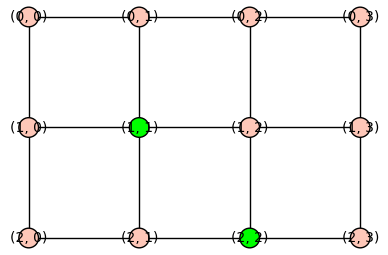

Situacija v času 1:


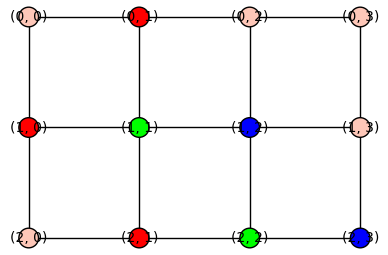

Situacija v času 2:


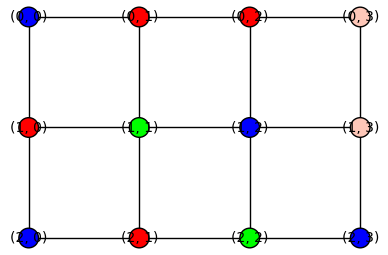

Situacija v času 3:


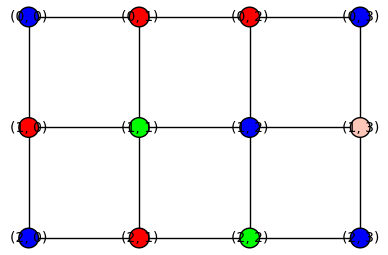

In [91]:
# PRIMER 1:
G1 = graphs.Grid2dGraph(3, 4)
B1 = [(1, 1), (2, 2)]
gasilci1 = 2
cas1 = 10
barvanje_po_korakih(G1, B1, gasilci1, cas1)

Število potrebnih časovnih korakov: 2
Situacija v času 0:


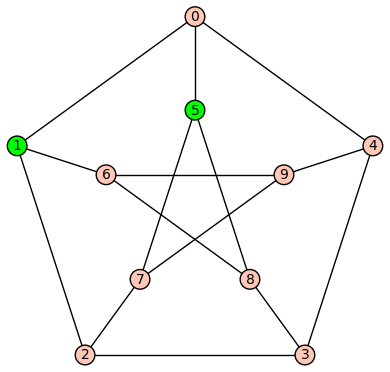

Situacija v času 1:


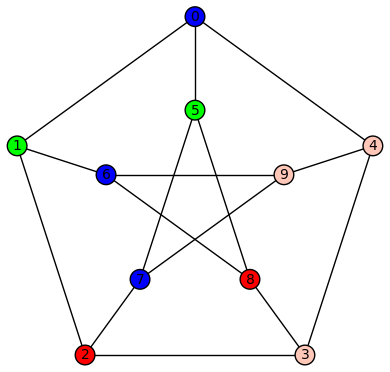

Situacija v času 2:


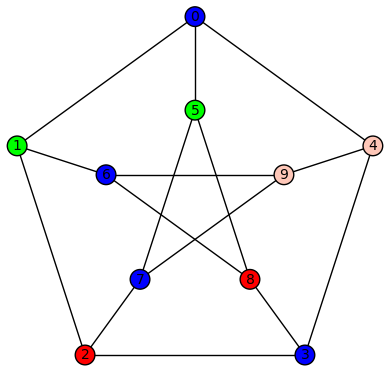

In [98]:
# PRIMER 2:
G2 = graphs.PetersenGraph()
B2 = [1,5]
gasilci2 = 3
cas2 = 10
barvanje_po_korakih(G2, B2, gasilci2, cas2)

Število potrebnih časovnih korakov: 3
Situacija v času 0:


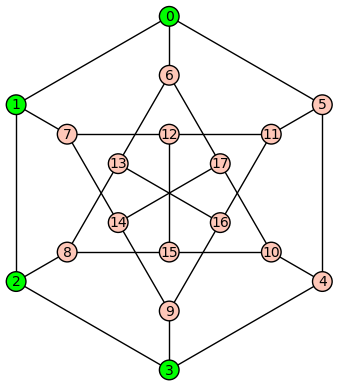

Situacija v času 1:


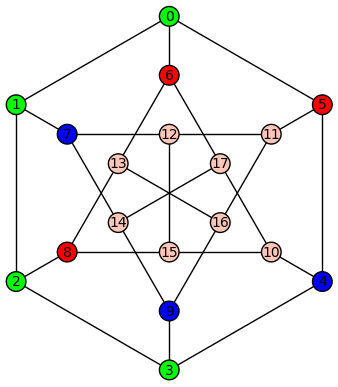

Situacija v času 2:


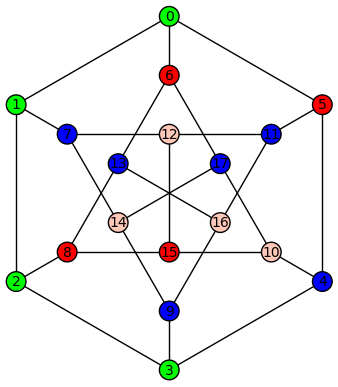

Situacija v času 3:


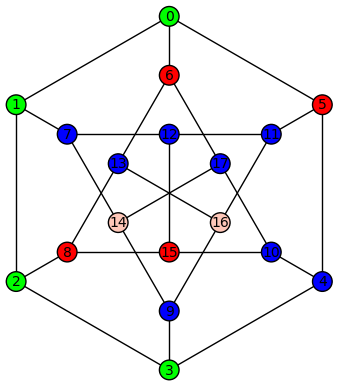

In [99]:
# PRIMER 3:
G3 = graphs.PappusGraph()
B3 = [0,1,2,3]
gasilci3 = 3
cas3 = 10
barvanje_po_korakih(G3, B3, gasilci3, cas3)